In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !cp drive/'My Drive'/BERT/Sarcasm_Headlines_Dataset_v2.json .

In [2]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 3.3MB/s 


In [3]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmplv8bscvx
100%|██████████| 231508/231508 [00:00<00:00, 2725158.72B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmplv8bscvx to cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmplv8bscvx
INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f0006

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F

from pytorch_pretrained_bert import BertConfig
from sklearn.model_selection import train_test_split


In [0]:
class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias
        

class BertForSequenceClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary. Items in the batch should begin with the special "CLS" token. (see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels=2):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.config = config
        #self.bert = BertModel(config=config) # Uncomment if you want to do castom config
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        nn.init.xavier_normal_(self.classifier.weight)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [0]:
config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

num_labels = 2

Defining BERT model:

In [7]:
model = BertForSequenceClassification(config, num_labels)

INFO:pytorch_pretrained_bert.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz not found in cache, downloading to /tmp/tmprzis412_
100%|██████████| 407873900/407873900 [00:05<00:00, 78428599.98B/s]
INFO:pytorch_pretrained_bert.file_utils:copying /tmp/tmprzis412_ to cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.file_utils:creating metadata file for /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.file_utils:removing temp file /tmp/tmprzis412_
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb7

Prepearing data:

In [8]:
import pandas as pd
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [0]:
X = df['headline']
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
X_train = X_train.tolist()
X_test = X_test.tolist()

y_train = y_train.tolist()
y_test = y_test.tolist()


As most headlines have length less then 24, we will define max_seq_length = 24:

In [0]:
max_seq_length = 24
class text_dataset(Dataset):
    def __init__(self,x_y_list, transform=None):
        
        self.x_y_list = x_y_list
        self.transform = transform
        
    def __getitem__(self,index):
        
        tokenized_review = tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_review) > max_seq_length:
            tokenized_review = tokenized_review[:max_seq_length]
            
        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

        padding = [0] * (max_seq_length - len(ids_review))
        
        ids_review += padding
        
        assert len(ids_review) == max_seq_length
        
        #print(ids_review)
        ids_review = torch.tensor(ids_review)
        
        sentiment = self.x_y_list[1][index] # color        
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        
        
        return ids_review, list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])

In [13]:
batch_size = 32

train_lists = [X_train, y_train]
test_lists = [X_test, y_test]

training_dataset = text_dataset(x_y_list = train_lists )

test_dataset = text_dataset(x_y_list = test_lists )

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    val_loss = []
    train_loss = []
    val_acc = []
    train_acc = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0          
            sentiment_corrects = 0
            tp = 0.0 #true poisitve
            tn = 0.0 #true negative
            fp = 0.0 #false positive
            fn = 0.0 #false negative
            
            # Iterate over data.
            for inputs, sentiment in dataloaders_dict[phase]:

                inputs = inputs.to(device) 
                sentiment = sentiment.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    outputs = F.softmax(outputs,dim=1)

                    loss = criterion(outputs, sentiment)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

                sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == sentiment)

                tp += torch.sum(torch.max(outputs, 1)[1] & sentiment)
                tn += torch.sum(1-torch.max(outputs, 1)[1] & 1-sentiment)
                fp += torch.sum(torch.max(outputs, 1)[1] & 1-sentiment)
                fn += torch.sum(1-torch.max(outputs, 1)[1] & sentiment)

                
            epoch_loss = running_loss / dataset_sizes[phase]

            sentiment_acc = sentiment_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc.append(sentiment_acc)
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(sentiment_acc)
                val_loss.append(epoch_loss)

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} sentiment_acc: {:.4f}'.format(
                phase, sentiment_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'bert_model_test.pth')

            if phase == 'val' and epoch == num_epochs - 1:
                recall = tp / (tp + fn)
                print('recall {:.2f}'.format(recall))

        print()
    
    confusion_matrix = [[int(tp), int(fp)],[int(fn), int(tn)]]
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(float(best_loss)))

    results = {'time': time_elapsed, 'recall': recall, 'conf_matr': confusion_matrix, 'val_loss': val_loss, 'train_loss': train_loss, 'val_acc': val_acc, 'train_acc': train_acc} 

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [15]:
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

We will use two learning rates: 1st is for classifier, so it can be more aggressive and 2nd one for pre-trained bert

In [0]:
lrlast = .001
lrmain = .00001
optimizer = optim.Adam(
    [
        {"params":model.bert.parameters(),"lr": lrmain},
        {"params":model.classifier.parameters(), "lr": lrlast},
       
   ])

criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)


In [17]:
model_fit, res = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=8)


starting
Epoch 1/8
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train total loss: 0.4906 
train sentiment_acc: 0.8114
val total loss: 0.4381 
val sentiment_acc: 0.8709
saving with loss of 0.43814353977026094 improved over previous 100

Epoch 2/8
----------
train total loss: 0.4288 
train sentiment_acc: 0.8796
val total loss: 0.4313 
val sentiment_acc: 0.8767
saving with loss of 0.4312747877265589 improved over previous 0.43814353977026094

Epoch 3/8
----------
train total loss: 0.4031 
train sentiment_acc: 0.9068
val total loss: 0.4096 
val sentiment_acc: 0.9006
saving with loss of 0.40960756852275254 improved over previous 0.4312747877265589

Epoch 4/8
----------
train total loss: 0.3808 
train sentiment_acc: 0.9305
val total loss: 0.4102 
val sentiment_acc: 0.8983

Epoch 5/8
----------
train total loss: 0.3762 
train sentiment_acc: 0.9352
val total loss: 0.4048 
val sentiment_acc: 0.9055
saving with loss of 0.404751583152847 improved over previous 0.40960756852275254

Epoch 6/8
----------
train total loss: 0.3751 
train sentiment_acc: 0.9360
val 

Lets see at test and train accuracy plots:

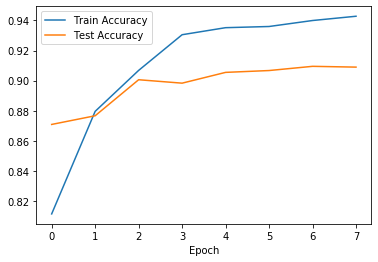

In [18]:
plt.plot(res['train_acc'], label = 'Train Accuracy')
plt.plot(res['val_acc'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.legend()

And confusion matrix:

In [19]:
pd.DataFrame(res['conf_matr'])

,0,1
0,2436,228
1,293,2767
